# PyHopper Tutorial

Here, we demonstrate a simple end-to-end example of how we can use PyHopper to find well-working hyperparameters of a machine learning model.

In [1]:
# We need to install hyhopper in our colab environment
!pip3 install -U pyhopper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.9 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import pyhopper

First, we have to define our objective that Pyhopper should optimize

In [3]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam

def objective(hparams: dict) -> float:
  # Our objective function gets the hyperparameters as a dictionary

  (x_train, y_train), (x_val, y_val) =  tf.keras.datasets.boston_housing.load_data()

  model = tf.keras.models.Sequential()
  for i in range(hparams["num_layers"]):
    # Number of neurons, the activation function and L2 decay factor will be tuned
    model.add(Dense(hparams["units"],hparams["activation"],kernel_regularizer=L2(hparams["l2_regularization"])))
    # Dropout rate as well
    model.add(Dropout(hparams["dropout"]))

  # We need to add a final layer for making the prediction
  model.add(Dense(1,kernel_regularizer=L2(hparams["l2_regularization"])))

  # Learning rate of our model will be optimized too
  model.compile(optimizer=Adam(hparams["lr"]),loss="mse")

  model.fit(x_train,y_train,batch_size=32,epochs=50,verbose=0)

  # After training the model, we evaluate it on the validation set
  # and use the validation loss as our objective score
  return model.evaluate(x_val,y_val,verbose=0)


Next, we have to define the search space as a ```dict``` with three possible object types:

- ```int```
- ```float```
- ```choice```

We can restrict the search space by limiting the precision of the floats, using logarithmic sampling, and defining integers as powers easily.

In [4]:
search = pyhopper.Search(
    {
        "num_layers": pyhopper.int(0,4),
        "units": pyhopper.int(64,512, power_of=2),
        "dropout": pyhopper.float(0,0.4, "0.1f"),
        "activation": pyhopper.choice(["relu","swish","tanh"]),
        "l2_regularization": pyhopper.choice([0,1e-5,1e-4], is_ordinal=True),
        "lr": pyhopper.float(1e-2,1e-4,"0.1g"),
    }
)

# An run the optimization for 1 minute
best_params = search.run(objective, "minimize", "1min",n_jobs=1)

  0%|          | [00:00<?]

Search is scheduled for 01:00 (m:s)
57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
================== Summary =================
Mode              : Best f : Steps : Time   
----------------  : ----   : ----  : ----   
Initial solution  : 72.56  : 1     : 11.47 s
Random seeding    : 50.1   : 1     : 9.39 s 
Local sampling    : 29.25  : 4     : 33 s   
----------------  : ----   : ----  : ----   
Total             : 29.25  : 6     : 54 s   


```search.run``` returns the best hyperparameter candidates found during the entire process

In [5]:
print("Best hpararam:", best_params)

Best hpararam: {'num_layers': 2, 'units': 256, 'dropout': 0.3, 'activation': 'tanh', 'l2_regularization': 1e-05, 'lr': 0.0009}


To gain some understanding of the hyperparameter sensitivity and objective surface, we can plot the evaluated scores over the runtime of the algorithm

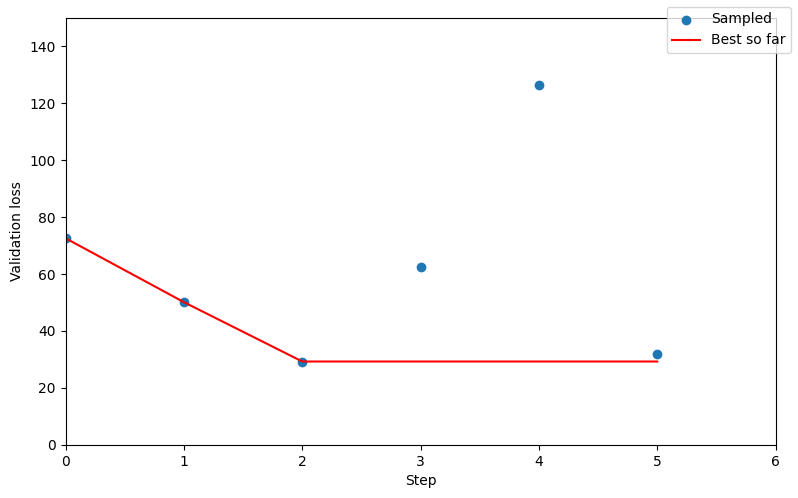

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(
    x=search.history.steps,
    y=search.history.fs,
    label="Sampled",
)
ax.plot(
    search.history.steps,
    search.history.best_fs,
    color="red",
    label="Best so far",
)
ax.set_xlim([0, len(search.history)])
ax.set_ylim([0,150])
ax.set_xlabel("Step")
ax.set_ylabel("Validation loss")
fig.legend(loc="upper right")
fig.tight_layout()
fig.show()